In [1]:
import tensorflow as tf

keras = tf.keras
import pandas as pd, numpy as np
import os, unidecode, glob
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from pylab import rcParams
rcParams['figure.figsize'] = (15, 8)

import math
from sklearn.metrics import mean_squared_error

In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [3]:
check_df = pd.concat([pd.read_parquet(f) for f in glob.glob(os.getcwd()+'/filtered_data/checkin/*.parquet')], ignore_index=True)

check_df['date'] = check_df.date.apply(lambda x: x.split(','))
check_df = check_df.explode('date').reset_index().drop('index',axis=1)
check_df['date'] = pd.to_datetime(check_df.date)

In [4]:
bus_df = pd.concat([pd.read_parquet(f) for f in glob.glob(os.getcwd()+'/filtered_data/business/*.parquet')], ignore_index=True)

bus_df['city'] = bus_df.city.apply(lambda x: unidecode.unidecode(x))
bus_df['state'] = np.select(
    [
        bus_df['city'].isin(['Toronto', 'Richmond Hill', 'Scarborough', 'Markham', 'Mississauga', 'Brampton', 'Vaughan', 'North York']),
        bus_df['city'].isin(['Calgary']),
        bus_df['city'].isin(['Montreal']),
    ],
    [
        'ON',
        'AB',
        'QC'
    ]
)

In [5]:
df = bus_df[['business_id','city']].merge(check_df,on=['business_id'],how='inner')
df['city'] = df.city.astype('category')
df = df.assign(date=df.date.dt.round('H'))
df.head()

,business_id,city,date
0,EosRKXIGeSWFYWwpkbhNnA,Toronto,2012-06-12 19:00:00
1,EosRKXIGeSWFYWwpkbhNnA,Toronto,2013-02-11 15:00:00
2,EosRKXIGeSWFYWwpkbhNnA,Toronto,2013-02-22 18:00:00
3,EosRKXIGeSWFYWwpkbhNnA,Toronto,2013-03-05 21:00:00
4,EosRKXIGeSWFYWwpkbhNnA,Toronto,2013-03-06 17:00:00


In [6]:
pivot_df = df.pivot_table(index='date',values='business_id',columns='city',aggfunc='count', fill_value=0)
pivot_df.index = pd.DatetimeIndex(pivot_df.index)
pivot_df

city,Brampton,Calgary,Markham,Mississauga,Montreal,North York,Richmond Hill,Scarborough,Toronto,Vaughan
date,,,,,,,,,,
2010-01-16 02:00:00,0,1,0,0,0,0,0,0,0,0
2010-01-16 05:00:00,0,0,0,0,0,0,0,0,1,0
2010-01-16 10:00:00,0,0,0,0,0,0,0,0,2,0
2010-01-16 13:00:00,0,0,0,0,0,0,0,0,1,0
2010-01-16 15:00:00,0,1,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...
2019-12-13 13:00:00,0,0,0,0,0,1,1,0,4,0
2019-12-13 14:00:00,0,0,0,0,0,0,1,0,4,0
2019-12-13 15:00:00,0,0,3,1,2,0,0,0,5,0


In [7]:
daily_tor = pivot_df.loc[:,'Toronto'].resample('D').sum().reset_index().rename(columns={'date':'ds','Toronto':'y'}).set_index('ds')

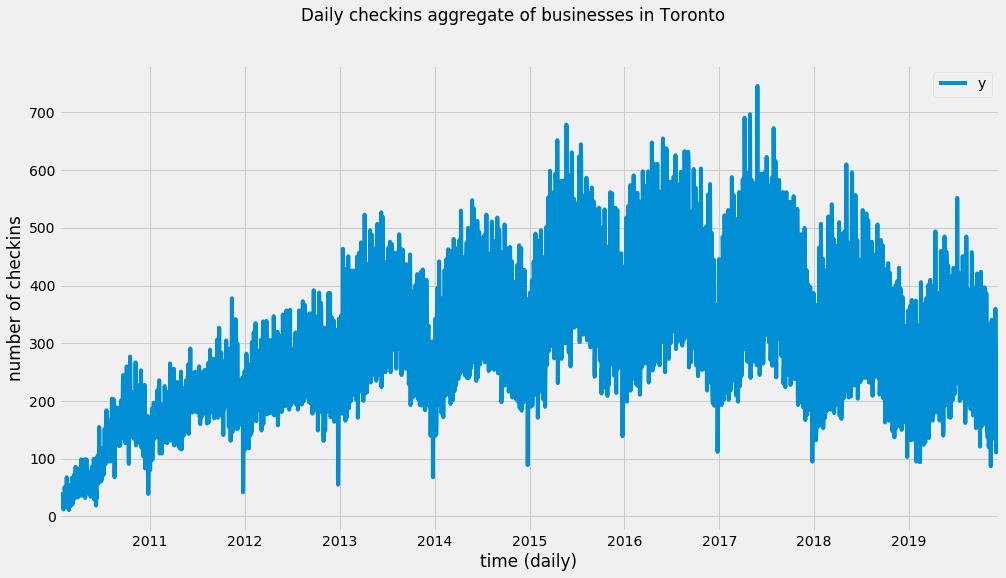

In [8]:
fig, ax = plt.subplots()
daily_tor.plot(ax=ax)
fig.suptitle('Daily checkins aggregate of businesses in Toronto')
ax.set(xlabel='time (daily)',ylabel=('number of checkins'))
plt.legend()
plt.show()

## Forecasting

In [28]:
def train_test_split(ts_df):
    test_split = '2019-01-01'
    train = ts_df.loc[ts_df.index < test_split].copy()
    test = ts_df.loc[(ts_df.index >= test_split)].copy()
    print(train.shape)
    print(test.shape)
    return (train,test)

d_train, d_test = train_test_split(daily_tor.loc[daily_tor.index > '2012-12-31'])
val_size = d_test.shape[0]
error_vals = list()

(2191, 1)
(347, 1)


In [29]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [30]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

### Linear Model

In [31]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 8
train_set = window_dataset(d_train[:val_size].y, window_size)
valid_set = window_dataset(d_train[val_size:].y, window_size)

lin_model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
lin_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
lin_model.fit(train_set, epochs=100,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/100
11/11 [==============================] - 1s 51ms/step - loss: 846.8800 - mae: 852.8866 - val_loss: 647.5517 - val_mae: 647.7500
Epoch 2/100
11/11 [==============================] - 0s 22ms/step - loss: 295.7703 - mae: 304.2992 - val_loss: 128.8498 - val_mae: 129.4818
Epoch 3/100
11/11 [==============================] - 0s 19ms/step - loss: 181.4763 - mae: 184.1170 - val_loss: 136.3500 - val_mae: 136.5928
Epoch 4/100
11/11 [==============================] - 0s 21ms/step - loss: 95.4168 - mae: 95.5337 - val_loss: 112.5107 - val_mae: 112.7967
Epoch 5/100
11/11 [==============================] - 0s 22ms/step - loss: 82.5206 - mae: 82.5919 - val_loss: 95.3215 - val_mae: 95.7217
Epoch 6/100
11/11 [==============================] - 0s 24ms/step - loss: 68.7641 - mae: 69.3843 - val_loss: 85.5021 - val_mae: 86.2732
Epoch 7/100
11/11 [==============================] - 0s 28ms/step - loss: 64.7389 - mae: 65.1130 - val_loss: 76.0123 - val_mae: 76.1892
Epoch 8/100
11/11 [===============

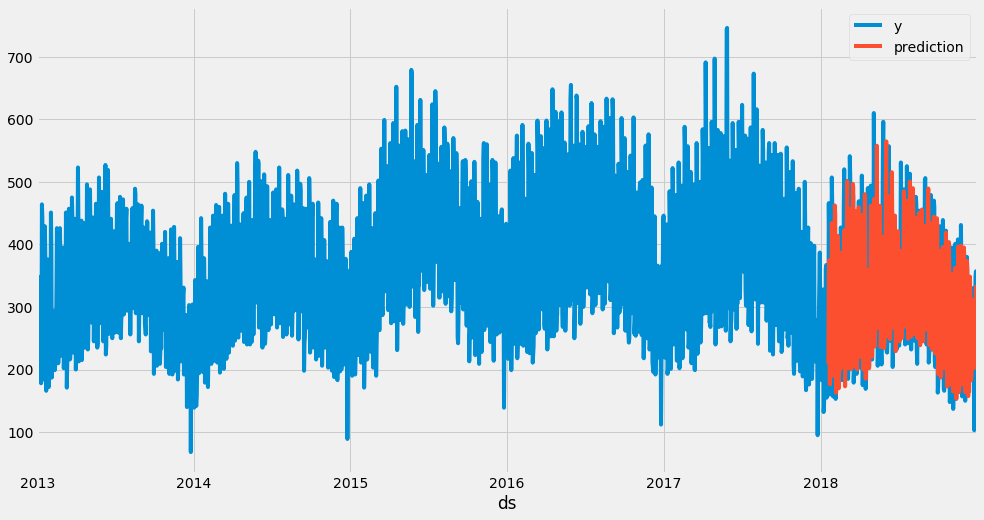

In [32]:
lin_predict = model_forecast(lin_model, d_train[-val_size-window_size:-1].y, window_size)[:, 0]
pred = pd.DataFrame(lin_predict, \
            index=d_train[-val_size:].index,
            columns=['prediction'])

fig, ax = plt.subplots()
d_train.plot(label='observed',ax=ax)
pred.plot(ax=ax)
plt.legend()
plt.show()

In [33]:
rmse_train = math.sqrt(mean_squared_error(d_train[-val_size:], pred.prediction))
print("The root mean squared error is {}.".format(rmse_train))

The root mean squared error is 47.229197561329656.


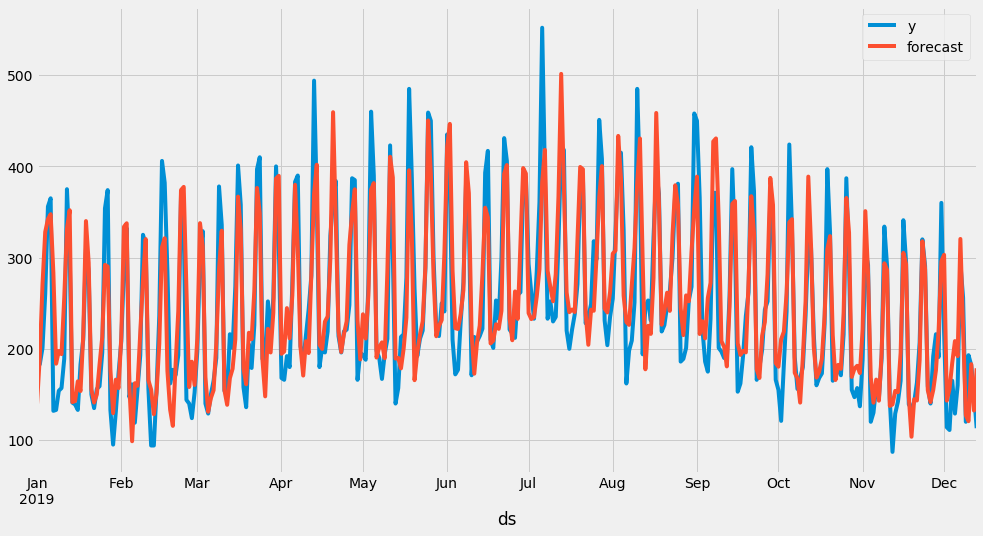

In [34]:
lin_forecast = model_forecast(lin_model, pd.concat([d_train[-window_size:],d_test[:-1]]).y, window_size)[:, 0]
fcast = pd.DataFrame(lin_forecast, \
            index=d_test.index,
            columns=['forecast'])

fig, ax = plt.subplots()
d_test.plot(ax=ax)
fcast.plot(ax=ax)
plt.legend()
plt.show()

In [35]:
rmse_test = math.sqrt(mean_squared_error(d_test, fcast))
print("The root mean squared error is {}.".format(rmse_test))

The root mean squared error is 43.87590585389132.


In [36]:
mape = np.mean(np.abs(d_test.values - fcast.values) / d_test.values) * 100
print("The mean average percentage error is {}.".format(mape))

The mean average percentage error is 14.572538595988183.


In [37]:
error_vals.append(('Linear Model',rmse_train,rmse_test,mape))

### Dense Model

In [38]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 8
train_set = window_dataset(d_train[:val_size].y, window_size)
valid_set = window_dataset(d_train[val_size:].y, window_size)

den_model = keras.models.Sequential([
  keras.layers.Dense(10, activation='relu', input_shape=[window_size]),
  keras.layers.Dense(10, activation='relu'),
  keras.layers.Dense(10, activation='relu'),
  keras.layers.Dense(1),
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
den_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
den_model.fit(train_set, epochs=200,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/200
11/11 [==============================] - 1s 75ms/step - loss: 310.0503 - mae: 311.5644 - val_loss: 277.8062 - val_mae: 278.0865
Epoch 2/200
11/11 [==============================] - 0s 25ms/step - loss: 167.0287 - mae: 171.4012 - val_loss: 74.8567 - val_mae: 75.4085
Epoch 3/200
11/11 [==============================] - 0s 27ms/step - loss: 81.5970 - mae: 82.7426 - val_loss: 64.5050 - val_mae: 64.9627
Epoch 4/200
11/11 [==============================] - 0s 25ms/step - loss: 57.6415 - mae: 58.4907 - val_loss: 60.3741 - val_mae: 60.8661
Epoch 5/200
11/11 [==============================] - 0s 26ms/step - loss: 40.3496 - mae: 41.0268 - val_loss: 44.7610 - val_mae: 45.2184
Epoch 6/200
11/11 [==============================] - 0s 26ms/step - loss: 34.9107 - mae: 35.8814 - val_loss: 42.8843 - val_mae: 43.2964
Epoch 7/200
11/11 [==============================] - 0s 25ms/step - loss: 33.9027 - mae: 34.3637 - val_loss: 39.0692 - val_mae: 39.3770
Epoch 8/200
11/11 [=======================

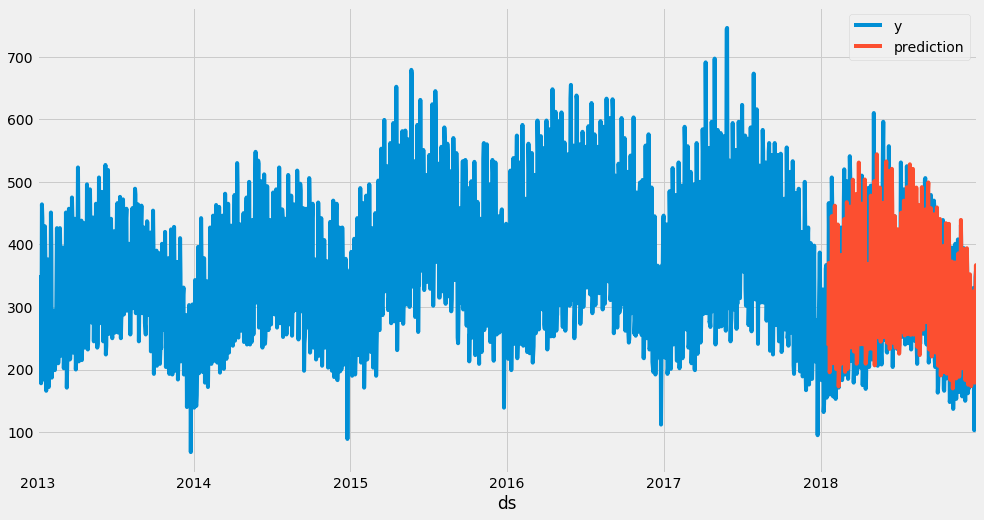

In [39]:
dense_predict = model_forecast(den_model, d_train[-val_size-window_size:-1].y, window_size)[:, 0]
pred = pd.DataFrame(dense_predict, \
            index=d_train[-val_size:].index,
            columns=['prediction'])

fig, ax = plt.subplots()
d_train.plot(label='observed',ax=ax)
pred.plot(ax=ax)
plt.legend()
plt.show()

In [40]:
rmse_train = math.sqrt(mean_squared_error(d_train[-val_size:], pred.prediction))
print("The root mean squared error is {}.".format(rmse_train))

The root mean squared error is 44.251960092280505.


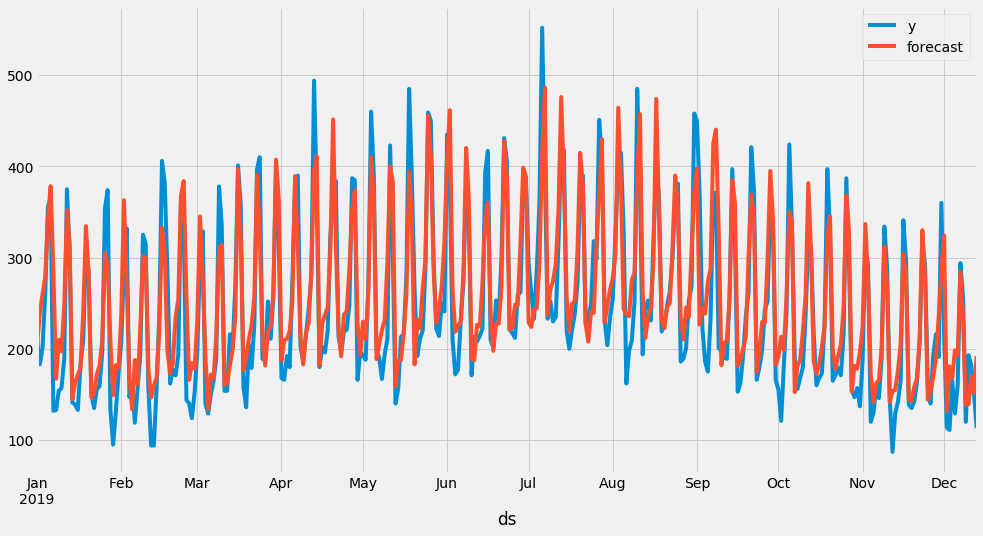

In [41]:
dense_forecast = model_forecast(den_model, pd.concat([d_train[-window_size:],d_test[:-1]]).y, window_size)[:, 0]
fcast = pd.DataFrame(dense_forecast, \
            index=d_test.index,
            columns=['forecast'])

fig, ax = plt.subplots()
d_test.plot(ax=ax)
fcast.plot(ax=ax)
plt.legend()
plt.show()

In [42]:
rmse_test = math.sqrt(mean_squared_error(d_test, fcast))
print("The root mean squared error is {}.".format(rmse_test))

The root mean squared error is 42.60375489464548.


In [43]:
mape = np.mean(np.abs(d_test.y.values - fcast.forecast.values) / d_test.y.values) * 100
print("The mean average percentage error is {}.".format(mape))

The mean average percentage error is 14.999017991484504.


In [44]:
error_vals.append(('Dense Model',rmse_train,rmse_test,mape))

In [45]:
errors = dict()
errors['model'] = []
errors['rmse_train'] = []
errors['rmse_test'] = []
errors['mape'] = []

for row in error_vals:
    errors['model'].append(row[0])
    errors['rmse_train'].append(row[1])
    errors['rmse_test'].append(row[2])
    errors['mape'].append(row[3])

pd.DataFrame(errors)

,model,rmse_train,rmse_test,mape
0,Linear Model,47.229198,43.875906,14.572539
1,Dense Model,44.251960,42.603755,14.999018


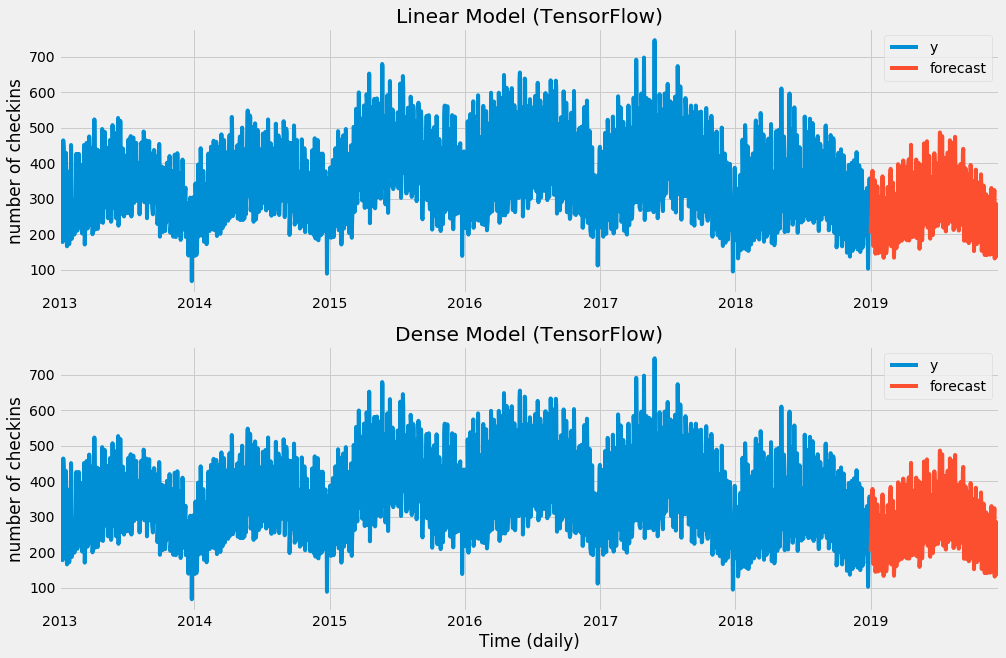

In [69]:
fig,ax = plt.subplots(2,1,figsize=(15,10))

d_train.plot(ax=ax[0], label='daily checkins')
lin_forecast = model_forecast(lin_model, pd.concat([d_train[-window_size:],d_test[:-1]]).y, window_size)[:, 0]
fcast = pd.DataFrame(dense_forecast, \
            index=d_test.index,
            columns=['forecast'])
fcast.plot(ax=ax[0])

d_train.plot(ax=ax[1], label='daily checkins')
dense_forecast = model_forecast(den_model, pd.concat([d_train[-window_size:],d_test[:-1]]).y, window_size)[:, 0]
fcast = pd.DataFrame(dense_forecast, \
            index=d_test.index,
            columns=['forecast'])
fcast.plot(ax=ax[1])

ax[0].set(title='Linear Model (TensorFlow)',xlabel='',ylabel='number of checkins')
ax[1].set(title='Dense Model (TensorFlow)',xlabel='Time (daily)',ylabel='number of checkins')
plt.show()